In [1]:
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)
import xarray as xr

import h5py
import cartopy.crs as ccrs
    
from mydedalustools import *    

%load_ext autoreload
%autoreload 2

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1


/global/common/software/m3310/conda/dedalus3/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


This notebook presents two tests of a linear shallow water stationary wave model: A stationary orographic Rossby wave in midlatitudes, and a Gill pattern in the tropics.

In [2]:
# Simulation units
meter = 1 / 6.37122e6
hour = 1
second = hour / 3600
day = hour*24
Kelvin = 1

# Earth parameters
R0 = 6.4e6*meter
Omega = 2*np.pi/86400 / second

SNAPSHOTS_DIR = "/pscratch/sd/q/qnicolas/stationarywave_snapshots/"

# Shallow water stationary Rossby wave

To obtain the solutions, run "mpiexec -n 8 python stationarywave_SW.py" with the lhs option turned to True, then to False

In [3]:
snapshot_id = 'stationarywave_SW_rhs'
swrhs = open_h5(snapshot_id,'s1',SNAPSHOTS_DIR=SNAPSHOTS_DIR)
snapshot_id = 'stationarywave_SW_lhs'
swlhs = open_h5(snapshot_id,'s1',SNAPSHOTS_DIR=SNAPSHOTS_DIR)

## Basic-state wind and geopotential, topography

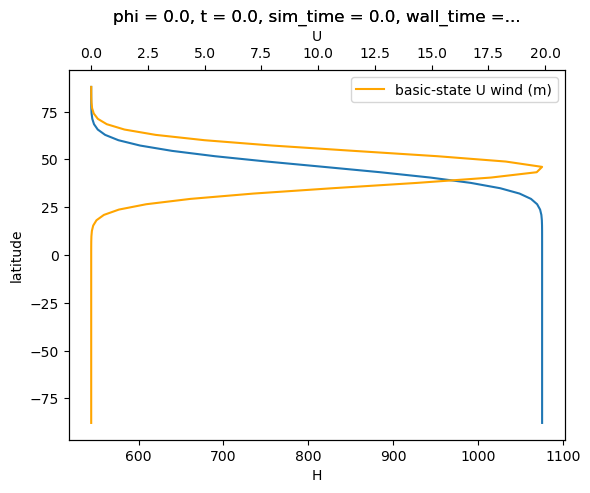

In [4]:
(swrhs.H[0,0]/meter).plot(y='latitude',label='basic-state height field (m)')
plt.twiny()
(swrhs.U[0,0,0]/(meter/second)).plot(y='latitude',color='orange',label='basic-state U wind (m)')
plt.legend()

Text(0.5, 1.0, 'Topography (m)')

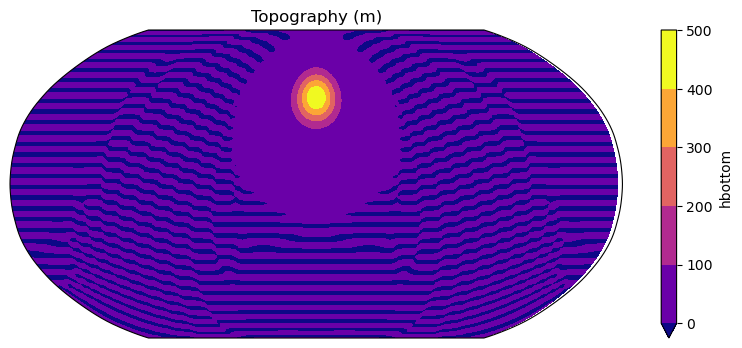

In [5]:
# Topography
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
(swrhs.hbottom[0]/meter).transpose().plot.contourf(ax=ax,levels=np.arange(0,501,100.),transform=ccrs.PlateCarree(),cmap=plt.cm.plasma)
plt.title('Topography (m)')

## time evolution

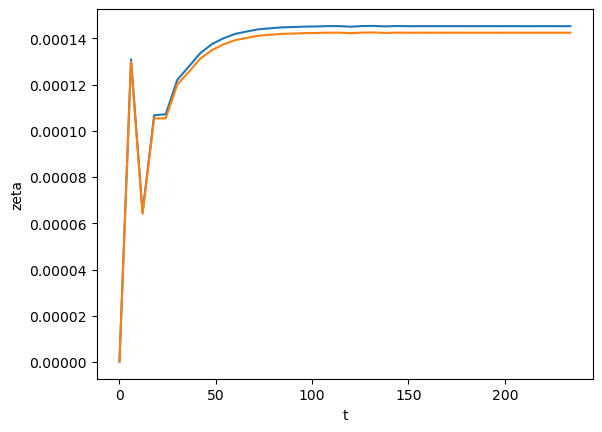

In [6]:
# Evolution of the mean enstrophy
(swrhs.zeta**2).mean(('latitude','longitude')).plot()
(swlhs.zeta**2).mean(('latitude','longitude')).plot()

## Solution

In [7]:
swrhs_mean = swrhs.sel(t=slice(150,None)).mean('t').transpose('','latitude','longitude')
swlhs_mean = swlhs.sel(t=slice(150,None)).mean('t').transpose('','latitude','longitude')

Text(0.5, 1.0, 'perturbation vorticity in rhs run')

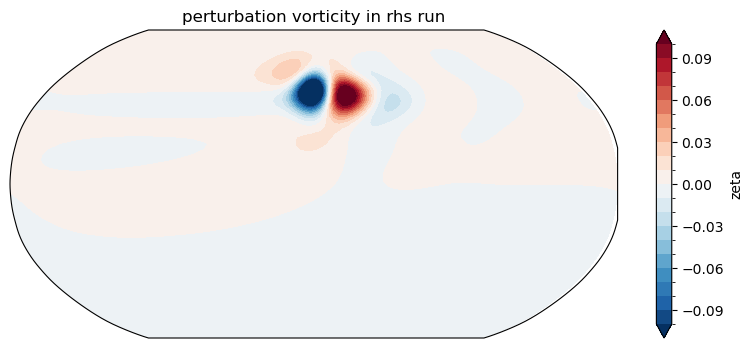

In [10]:
# Perturbation vorticity in rhs run
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
swrhs_mean.zeta.plot.contourf(ax=ax,levels=np.linspace(-0.1,0.1,21),extend='both',transform=ccrs.PlateCarree())
ax.set_title('perturbation vorticity in rhs run')

Text(0.5, 1.0, 'Difference in perturbation vorticity between rhs and lhs runs')

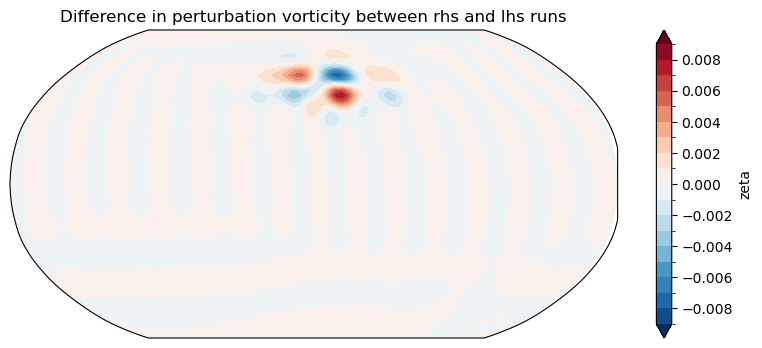

In [11]:
# Perturbation vorticity in lhs run
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
(swrhs_mean-swlhs_mean).zeta.plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree())
ax.set_title('Difference in perturbation vorticity between rhs and lhs runs')

Text(0.5, 1.0, 'total geopotential height, wind, and topography (white contour)')

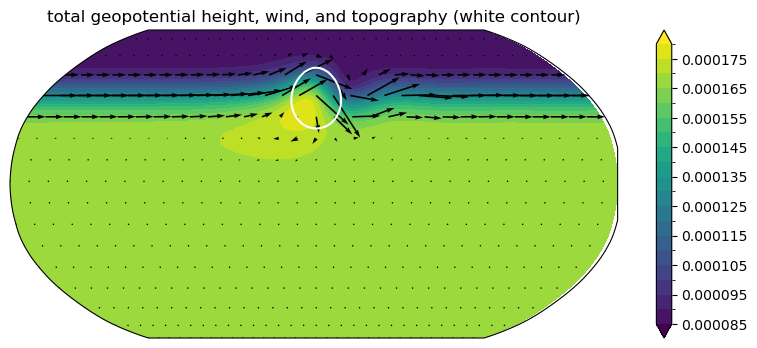

In [12]:
# Total geopotential height and U wind
Sim = swrhs_mean
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
(Sim.H[:,0]+Sim.hbottom+Sim.h).plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree())
Sim.hbottom.plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[1e2 * meter ],colors='w')

u= (Sim.U[0,:,0]+Sim.u[0])
v=-(Sim.U[1,:,0]+Sim.u[1])
n=4; m=n
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
Q = ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m],color="k",transform=ccrs.PlateCarree(),scale=0.2)

plt.title('total geopotential height, wind, and topography (white contour)')

Text(0.5, 1.0, 'Perturbation geopotential height, wind, and topography (white contour)')

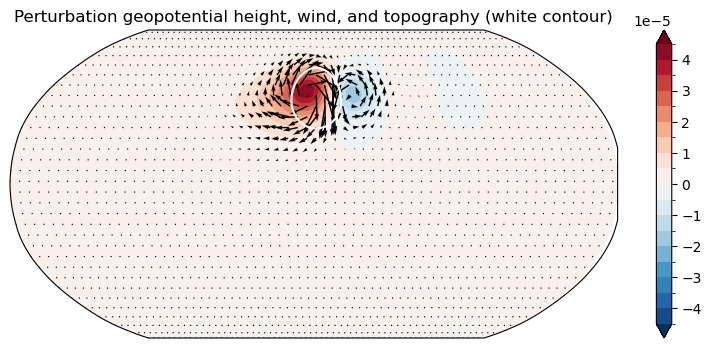

In [15]:
# Perturbation geopotential height and U wind
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
(Sim.hbottom+Sim.h).plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree())
Sim.hbottom.plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[1e2 * meter ],colors='w')

u= (Sim.u[0])
v=-(Sim.u[1])
n=2; m=n
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
Q = ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m],color="k",transform=ccrs.PlateCarree(),scale=0.2)

plt.title('Perturbation geopotential height, wind, and topography (white contour)')

# Gill problem

Here the basic state is at rest, and we impose zero topography.
A mass sink of magnitude 10 m / day is imposed at the equator

In [17]:
snapshot_id = 'stationarywave_SW_lhs_gill'
gill = open_h5(snapshot_id,'s1',SNAPSHOTS_DIR=SNAPSHOTS_DIR)

## time evolution

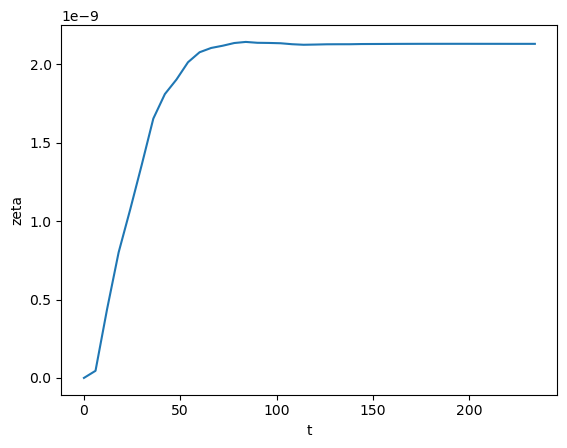

In [18]:
# Evolution of the mean enstrophy
(gill.zeta**2).mean(('latitude','longitude')).plot()

## Solution

In [21]:
gill_mean = gill.sel(t=slice(150,500)).mean('t').transpose('','latitude','longitude')


In [22]:
lat = np.pi/2-gill_mean.theta
lon = gill_mean.phi-np.pi
deltalat = np.pi/20
deltalon = np.pi/20

heating_shape = np.exp(-(lat)**2/(2*deltalat**2)) * np.exp(-(lon)**2/(2*deltalon**2))

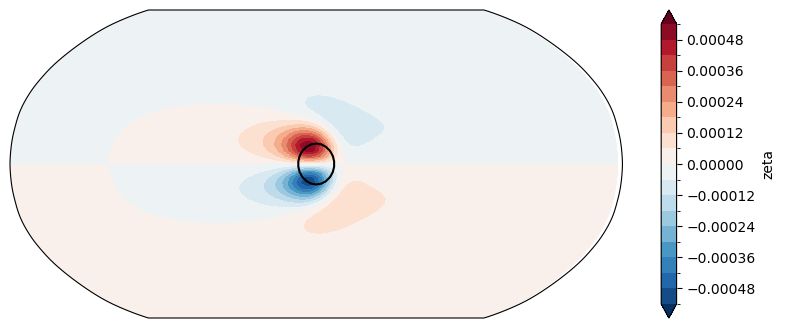

In [23]:
# Perturbation vorticity in gill run
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
gill_mean.zeta.plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree())

heating_shape.plot.contour(ax=ax,levels=[0.5],colors=['k'],transform=ccrs.PlateCarree())


Text(0.5, 1.0, 'divergence, wind, and heating (black contour)')

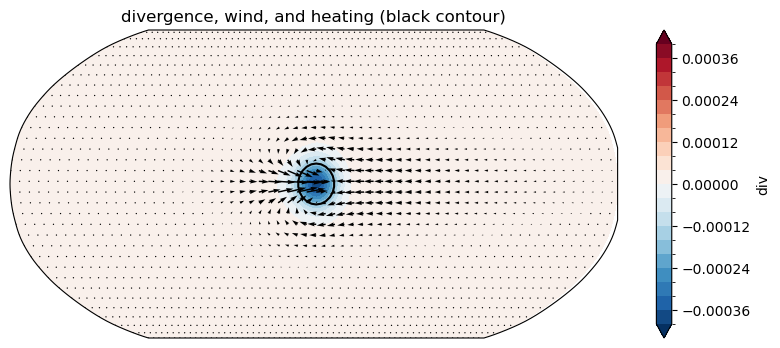

In [24]:
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
gill_mean.div.plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree())
heating_shape.plot.contour(ax=ax,levels=[0.5],colors=['k'],transform=ccrs.PlateCarree())

u= (gill_mean.u[0])
v=-(gill_mean.u[1])
n=2; m=n
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
Q = ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m],color="k",transform=ccrs.PlateCarree(),scale=2e-3)

plt.title('divergence, wind, and heating (black contour)')

Text(0.5, 1.0, 'divergence and heating (black contour)')

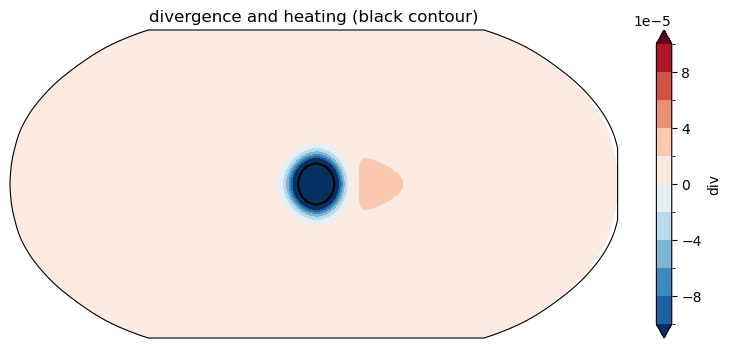

In [25]:
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
gill_mean.div.plot.contourf(ax=ax,levels=np.linspace(-1,1,11)/1e4,extend='both',transform=ccrs.PlateCarree())
heating_shape.plot.contour(ax=ax,levels=[0.5],colors=['k'],transform=ccrs.PlateCarree())

plt.title('divergence and heating (black contour)')

Text(0.5, 1.0, 'height and heating (black contour)')

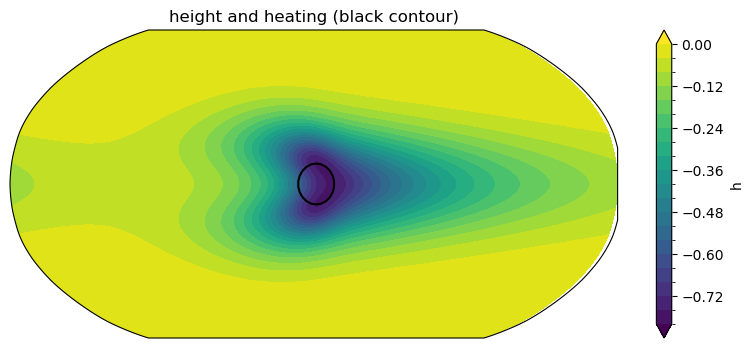

In [26]:
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
(gill_mean.h/meter).plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree())
heating_shape.plot.contour(ax=ax,levels=[0.5],colors=['k'],transform=ccrs.PlateCarree())

plt.title('height and heating (black contour)')